# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [48]:
# Read out CSV

df = pd.read_csv('UCI_Credit_Card.csv', sep=',')
df = df.sample(1400)

In [49]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [50]:
df.shape

(1400, 25)

In [51]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [52]:
df_labels = df['default.payment.next.month']
df.drop(['default.payment.next.month'],axis = 1,inplace = True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [54]:
np.unique(df_labels)

tensor([0, 1], requires_grad=True)

In [55]:
np.shape(X_train)

(1120, 24)

In [56]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [57]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [58]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [59]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [60]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

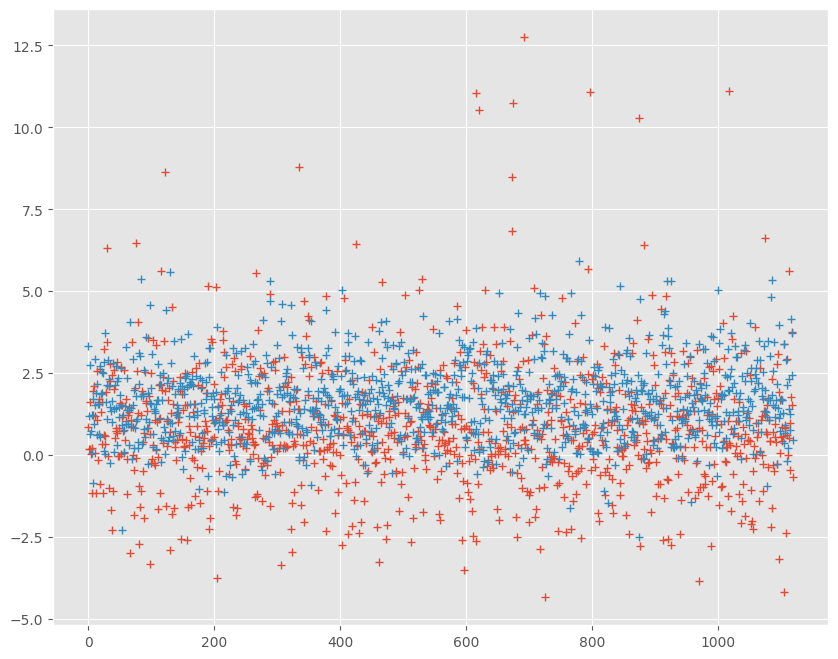

In [61]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [62]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [63]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [64]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [65]:
#result_predict = svc.predict(sample_test)

In [66]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [67]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('QSVC', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [68]:
df_results = pd.DataFrame()

In [69]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

100%|██████████████████████████████████████████| 6/6 [1:05:26<00:00, 654.50s/it]

               fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)        0.23        0.17           74.12        28.58    40.66   
LR std (%)         0.32        0.06           15.51         8.58    10.14   
KNN mean (%)       0.04        0.23           59.37        36.18    43.85   
KNN std (%)        0.01        0.05            9.33         9.87     8.48   
CART mean (%)      0.16        0.15           34.40        36.70    35.13   
CART std (%)       0.09        0.04            8.39        13.78    10.53   
NB mean (%)        0.07        0.17           66.66        25.42    36.27   
NB std (%)         0.08        0.06           14.72         9.45    11.71   
SVM mean (%)       0.59        0.25           83.45        28.62    41.83   
SVM std (%)        0.07        0.02           16.05         8.78    10.09   
qsvc mean (%)  33149.72     6117.63            0.00         0.00     0.00   
qsvc std (%)    7395.63      725.12            0.00         0.00     0.00   

In [70]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.23,0.17,74.12,28.58,40.66,80.62,37.16,62.64
LR std (%),0.32,0.06,15.51,8.58,10.14,3.76,11.54,4.72
KNN mean (%),0.04,0.23,59.37,36.18,43.85,78.62,33.71,63.97
KNN std (%),0.01,0.05,9.33,9.87,8.48,3.85,8.71,4.67
CART mean (%),0.16,0.15,34.40,36.70,35.13,69.00,15.15,57.94
CART std (%),0.09,0.04,8.39,13.78,10.53,5.15,13.59,7.37
NB mean (%),0.07,0.17,66.66,25.42,36.27,79.50,31.74,60.82
NB std (%),0.08,0.06,14.72,9.45,11.71,3.59,12.55,5.00
SVM mean (%),0.59,0.25,83.45,28.62,41.83,81.50,41.00,63.23
SVM std (%),0.07,0.02,16.05,8.78,10.09,3.78,11.03,4.59


In [88]:
j = 0
for i in range(int(len(df_results.index)/2)):

    print(f'{df_results.iloc[j].name.split()[0]} & {df_results.iloc[j][2]} ({df_results.iloc[j+1][2]}) & {df_results.iloc[j][3]} ({df_results.iloc[j+1][3]}) &  {df_results.iloc[j][4]} ({df_results.iloc[j+1][4]}) & {df_results.iloc[j][6]} ({df_results.iloc[j+1][6]}) & {df_results.iloc[j][7]} ({df_results.iloc[j+1][7]}) \\')
    
    j+=2

LR & 74.12 (15.51) & 28.58 (8.58) &  40.66 (10.14) & 37.16 (11.54) & 62.64 (4.72) \
KNN & 59.37 (9.33) & 36.18 (9.87) &  43.85 (8.48) & 33.71 (8.71) & 63.97 (4.67) \
CART & 34.4 (8.39) & 36.7 (13.78) &  35.13 (10.53) & 15.15 (13.59) & 57.94 (7.37) \
NB & 66.66 (14.72) & 25.42 (9.45) &  36.27 (11.71) & 31.74 (12.55) & 60.82 (5.0) \
SVM & 83.45 (16.05) & 28.62 (8.78) &  41.83 (10.09) & 41.0 (11.03) & 63.23 (4.59) \
qsvc & 0.0 (0.0) & 0.0 (0.0) &  0.0 (0.0) & 0.0 (0.0) & 50.0 (0.0) \


## Pennylane

In [71]:
from pennylane import numpy as np

In [72]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [73]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [74]:
circuit(weights_init, sample_train[0])

tensor(-0.14378827, requires_grad=True)

In [75]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [76]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [77]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [78]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [79]:
pd.Series(label_test).value_counts()

0    157
1     43
Name: default.payment.next.month, dtype: int64

In [80]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(0.61076316, requires_grad=True), tensor(-0.24207548, requires_grad=True)], Y = -1
X = [tensor(-0.86344545, requires_grad=True), tensor(0.47640247, requires_grad=True)], Y = -1
X = [tensor(-0.13239903, requires_grad=True), tensor(-0.37212894, requires_grad=True)], Y = -1
X = [tensor(-0.28734614, requires_grad=True), tensor(-1.01208007, requires_grad=True)], Y = -1
X = [tensor(1.42529853, requires_grad=True), tensor(0.17117937, requires_grad=True)], Y = -1


In [81]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [82]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.8920701 | f1: 0.2137931 
Iter:     2 | Cost: 0.7812688 | f1: 0.1937984 
Iter:     3 | Cost: 0.8073145 | f1: 0.1085973 
Iter:     4 | Cost: 0.7685429 | f1: 0.1491228 
New best
Iter:     5 | Cost: 0.7339434 | f1: 0.2278481 
New best
Iter:     6 | Cost: 0.6527147 | f1: 0.3809524 
New best
Iter:     7 | Cost: 0.7276718 | f1: 0.4666667 
New best
Iter:     8 | Cost: 0.7930628 | f1: 0.4881210 
Iter:     9 | Cost: 0.7675826 | f1: 0.4719626 
Iter:    10 | Cost: 0.7309740 | f1: 0.4702842 
Iter:    11 | Cost: 0.7108039 | f1: 0.4725275 
Iter:    12 | Cost: 0.6874053 | f1: 0.4772727 
Iter:    13 | Cost: 0.6609138 | f1: 0.4773414 
Iter:    14 | Cost: 0.6384194 | f1: 0.4774194 
Iter:    15 | Cost: 0.6357774 | f1: 0.3565891 
Iter:    16 | Cost: 0.6536128 | f1: 0.1517857 
Iter:    17 | Cost: 0.6835087 | f1: 0.0943396 
Iter:    18 | Cost: 0.6746231 | f1: 0.1266968 
Iter:    19 | Cost: 0.6592526 | f1: 0.2074689 
Iter:    20 | Cost: 0.6371780 | f1: 0.3166023 
New best
Iter: 

In [83]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [84]:
pd.Series(Yte).value_counts()

-1.0    157
 1.0     43
dtype: int64

In [85]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.7331843642036475, Accuracy: 70.0%


In [86]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.80      0.82      0.81       157
         1.0       0.28      0.26      0.27        43

    accuracy                           0.69       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.69      0.69      0.69       200



In [ ]:
print(metrics.classification_report(Yte,predictions))

In [43]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 37.5%
    Recall: 33.33%
    f1: 35.29%
    Accuracy: 72.5%
    Matthew corcorref: 17.96%
    Balanced accuracy: 58.6%
    


In [87]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 25.58%
    Recall: 27.5%
    f1: 26.51%
    Accuracy: 69.5%
    Matthew corcorref: 7.3%
    Balanced accuracy: 53.75%
    


In [44]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.9704825 | Accuracy: 0.6837500 
New best
Iter:     2 | Cost: 0.9061978 | Accuracy: 0.7287500 
New best
Iter:     3 | Cost: 0.8109473 | Accuracy: 0.7675000 
New best
Iter:     4 | Cost: 0.7620751 | Accuracy: 0.7737500 
Iter:     5 | Cost: 0.7626517 | Accuracy: 0.7712500 
Iter:     6 | Cost: 0.7759584 | Accuracy: 0.7725000 
New best
Iter:     7 | Cost: 0.7870926 | Accuracy: 0.7775000 
New best
Iter:     8 | Cost: 0.7953279 | Accuracy: 0.7812500 
New best
Iter:     9 | Cost: 0.7899940 | Accuracy: 0.7875000 
New best
Iter:    10 | Cost: 0.7661932 | Accuracy: 0.7962500 
Iter:    11 | Cost: 0.7139245 | Accuracy: 0.7950000 
New best
Iter:    12 | Cost: 0.6770194 | Accuracy: 0.7962500 
Iter:    13 | Cost: 0.7016225 | Accuracy: 0.7787500 
Iter:    14 | Cost: 0.7375408 | Accuracy: 0.7737500 
Iter:    15 | Cost: 0.7144126 | Accuracy: 0.7762500 
Iter:    16 | Cost: 0.6924015 | Accuracy: 0.7862500 
Iter:    17 | Cost: 0.6851140 | Accuracy: 0.7687500 
Iter:    18 | Cost

In [45]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5575790059067254, Accuracy: 80.0%


In [46]:
print(metrics.classification_report(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89       160
         1.0       0.00      0.00      0.00        40

    accuracy                           0.80       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.64      0.80      0.71       200



In [47]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 0.0%
    Recall: 0.0%
    f1: 0.0%
    Accuracy: 80.0%
    Balanced accuracy: 80.0%
    Matthew corcorref: 0.0%
    
